In [1]:
from __future__ import print_function,division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets,models,transforms
import matplotlib.pyplot as plt
import os
import time
import copy

plt.ion()

In [2]:
#数据增强和归一化处理
data_transforms={'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                'val':transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
data_dir='hymenoptera_data'
image_dataset={x:datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x]) 
               for x in ['train','val']}
dataloaders={x:torch.utils.data.DataLoader(image_dataset[x],batch_size=4,shuffle=True,num_workers=4) 
            for x in ['train','val']}
dataset_size={x:len(image_dataset[x]) for x in ['train','val']}
class_names=image_dataset['train'].classes
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('trainset size:',dataset_size['train'],
     'valset size:',dataset_size['val'])
print(class_names)
print(device)

trainset size: 244 valset size: 153
['ants', 'bees']
cuda:0


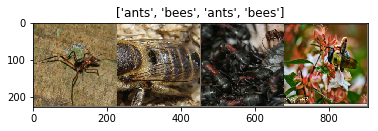

In [19]:
#visualize some image data
def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))  #torch to numpy
    mean=np.array([0.485, 0.456, 0.406])
    std=np.array([0.229, 0.224, 0.225])
    inp=std*inp+mean
    inp=np.clip(inp,0,1)   #像素值在区间[0,1]之间
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

#get a batch of training data
inputs,classes=next(iter(dataloaders['train']))
#make a grid of batch
out=torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [4]:
#train the model.criterion:代价函数；optimizer：优化函数
def train_model(model,criterion,optimizer,scheduler,num_epochs=25):
    since=time.time()
    
    best_model_wts=copy.deepcopy(model.state_dict())   #保存最优的模型参数
    best_acc=0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-'*10)
        
        #Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase=='train':
                scheduler.step()
                model.train()   #Set model to training model
            else:
                model.eval()   #Set model to evaluate model
            
            running_loss=0.0
            running_corrects=0
            
            #Iterate over data
            for inputs,labels in dataloaders[phase]:
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                optimizer.zero_grad()
                #forward. tracking history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs=model(inputs)
                    _,preds=torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                    
                    #backward+optimizer if only in train phase
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+=torch.sum(preds==labels.data)
            
            epoch_loss=running_loss/dataset_size[phase]
            epoch_acc=running_corrects.double()/dataset_size[phase]
            print('{} loss: {:.4f} Acc: {:.4f}'.format(phase,epoch_loss,epoch_acc))
            
            #deep copy the model.更新模型和参数
            if phase=='val' and epoch_acc>best_acc:
                best_acc=epoch_acc
                best_model_wts=copy.deepcopy(model.state_dict())
            
        print()
    
    time_elapsed=time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,time_elapsed%60))
    print('Best accuracy value:{:.4f}'.format(best_acc))
    
    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
#visualize model predictions
def visualize_model(model,num_images=6):
    was_training=model.training
    model.eval()
    image_so_far=0
    fig=plt.figure()
    
    with torch.no_grad():
        for i,(inputs,labels) in enumerate(dataloaders['val']):
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            outputs=model(inputs)
            _,preds=torch.max(outputs,1)
            
            for j in range(inputs.size()[0]):
                image_so_far+=1
                ax=plt.subplot(num_images//2,2,image_so_far)
                ax.axis('off')
                ax.set_title('predicted:{}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if image_so_far==num_images:
                    model.train(mode=was_training)
                    return 
        model.train(mode=was_training)

In [6]:
#fine-tuneing the convnet
model_ft=models.resnet18(pretrained=True)
num_ftrs=model_ft.fc.in_features    #全连接层的输入节点个数
model_ft.fc=nn.Linear(num_ftrs,2)   #构建输出层为2的神经网络

model_ft=model_ft.to(device)
criterion=nn.CrossEntropyLoss()   #定义代价函数
optimizer_ft=optim.SGD(model_ft.parameters(),lr=0.001,momentum=0.9)
#衰败因子0.1，每7周期衰败一次
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_ft,step_size=7,gamma=0.1)

model_ft=train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler)

Epoch 0/24
----------
train loss: 0.6496 Acc: 0.6598
val loss: 0.2041 Acc: 0.9412

Epoch 1/24
----------
train loss: 0.3647 Acc: 0.8402
val loss: 0.2705 Acc: 0.9020

Epoch 2/24
----------
train loss: 0.4538 Acc: 0.8074
val loss: 0.2309 Acc: 0.9020

Epoch 3/24
----------
train loss: 0.6434 Acc: 0.7172
val loss: 0.2746 Acc: 0.8889

Epoch 4/24
----------
train loss: 0.6107 Acc: 0.7828
val loss: 0.3848 Acc: 0.8693

Epoch 5/24
----------
train loss: 0.6807 Acc: 0.7541
val loss: 0.3147 Acc: 0.8954

Epoch 6/24
----------
train loss: 0.4432 Acc: 0.8525
val loss: 0.2672 Acc: 0.8889

Epoch 7/24
----------
train loss: 0.4380 Acc: 0.8484
val loss: 0.2443 Acc: 0.9150

Epoch 8/24
----------
train loss: 0.3183 Acc: 0.8607
val loss: 0.2363 Acc: 0.9216

Epoch 9/24
----------
train loss: 0.3526 Acc: 0.8607
val loss: 0.2411 Acc: 0.9216

Epoch 10/24
----------
train loss: 0.3542 Acc: 0.8402
val loss: 0.2751 Acc: 0.8758

Epoch 11/24
----------
train loss: 0.3088 Acc: 0.8525
val loss: 0.2256 Acc: 0.9216

Ep

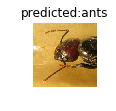

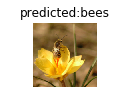

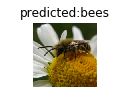

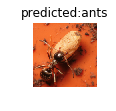

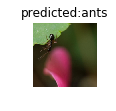

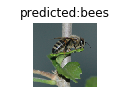

In [14]:
visualize_model(model_ft)

In [7]:
#convnet as fixed feature extractor
model_conv=models.resnet18(pretrained=True)
#将requiers_grad设置为False冻结参数
for param in model_conv.parameters():
    param.requires_grad=False
    
#新创建的模型参数默认为requiers_grad=True
num_ftrs=model_conv.fc.in_features
model_conv.fc=nn.Linear(num_ftrs,2)

model_conv=model_conv.to(device)
criterion=nn.CrossEntropyLoss()

#只有最后一层的参数会被优化
optimizer_conv=optim.SGD(model_conv.fc.parameters(),lr=0.001,momentum=0.9)
#LR衰减
exp_lr_scheduler=lr_scheduler.StepLR(optimizer_conv,step_size=7,gamma=0.1)

model_conv=train_model(model_conv,criterion,optimizer_conv,exp_lr_scheduler)

Epoch 0/24
----------
train loss: 0.6520 Acc: 0.6885
val loss: 0.5659 Acc: 0.6993

Epoch 1/24
----------
train loss: 0.4644 Acc: 0.7787
val loss: 0.1828 Acc: 0.9542

Epoch 2/24
----------
train loss: 0.3670 Acc: 0.8279
val loss: 0.2232 Acc: 0.9216

Epoch 3/24
----------
train loss: 0.2998 Acc: 0.8689
val loss: 0.1728 Acc: 0.9412

Epoch 4/24
----------
train loss: 0.6527 Acc: 0.7459
val loss: 0.2114 Acc: 0.9281

Epoch 5/24
----------
train loss: 0.3809 Acc: 0.8484
val loss: 0.2167 Acc: 0.9216

Epoch 6/24
----------
train loss: 0.5430 Acc: 0.7746
val loss: 0.4933 Acc: 0.8431

Epoch 7/24
----------
train loss: 0.4751 Acc: 0.8074
val loss: 0.1789 Acc: 0.9412

Epoch 8/24
----------
train loss: 0.3252 Acc: 0.8648
val loss: 0.1718 Acc: 0.9346

Epoch 9/24
----------
train loss: 0.3594 Acc: 0.8320
val loss: 0.1636 Acc: 0.9412

Epoch 10/24
----------
train loss: 0.4080 Acc: 0.8156
val loss: 0.1681 Acc: 0.9412

Epoch 11/24
----------
train loss: 0.2845 Acc: 0.8934
val loss: 0.1894 Acc: 0.9346

Ep

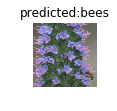

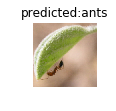

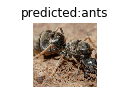

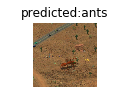

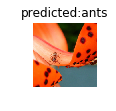

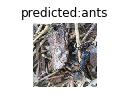

In [17]:
visualize_model(model_conv)
plt.ioff()
plt.show()